# 시나리오
- 여러 머신러닝 중 가장 좋은 알고리즘을 알아본다.

## 정형 데이터와 비정형 데이터
- 앞서 진행한 내용에 사용된 데이터들은 <b>정형 데이터(Structured Data)</b>
    - 가장 좋은 성능을 내는 것은 앙상블(ensemble) 학습(Tree기반)
- 텍스트, 이미지, 영상 등은 <b>비정형 데이터(Unstructured Data)</b>
    - 신경망 알고리즘을 사용



## 랜덤 포레스트(Random Forest)
- 앙상블 학습의 대표적인 모델
- 결정 트리를 랜덤하게 생성하여 숲(Forest)를 구성
- 숲을 이루는 각 결정트리 모델의 예측 결과를 이용하여 최종 예측을 만듦
- 라이브러리마다 조금씩 내부 구현에 차이가 있음

## 사이킷 런에서 제공되는 랜덤 포레스트의 동작
- 각 트리를 훈련하기 위한 데이터를 랜덤하게 생성
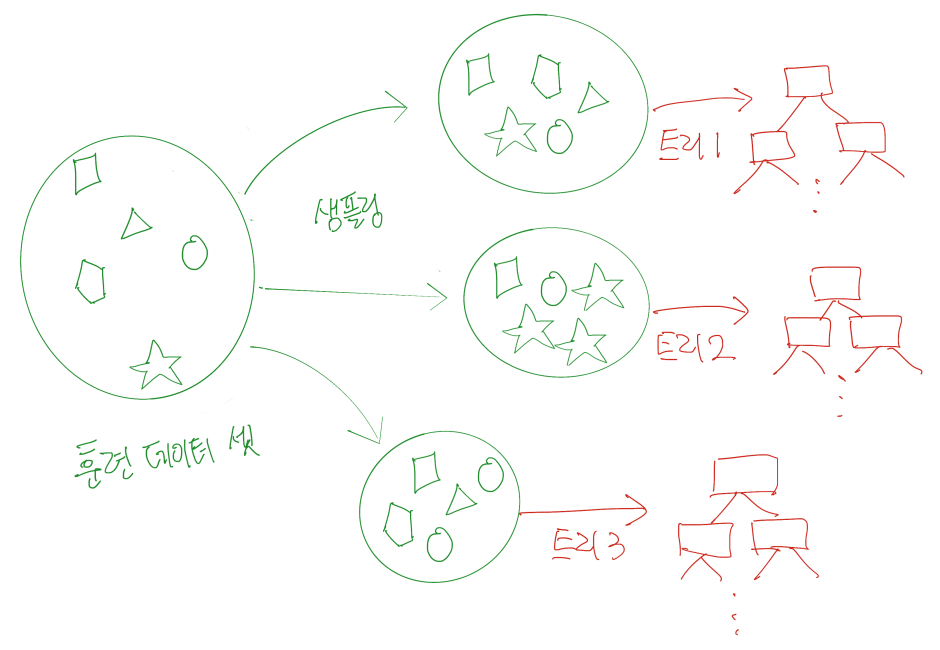
- 부트스트랩(bootstrap) 샘플
    - 데이터셋에서 중복을 허용하여 데이터 샘플링 하는 방식(부트스트랩)
    - 기본적으로 추출된 샘플은 훈련 세트와 크기(갯수)가 같음
    - 각 노드 분할 시 전체 특성에서 일부 특성을 무작위로 골라 최선의 분할을 찾음(전체 특성 개수의 제곱근 개수)
    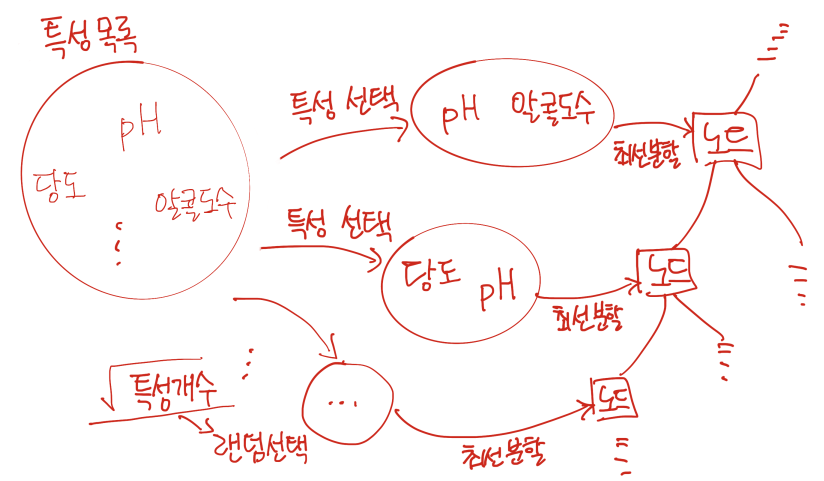
    - 기본적으로 100개의 결정트리를 위와 같은 방식으로 훈련 진행
    - 분류일 때는 각 트리의 클래스별 확률을 평균하여 가장 높은 확률을 가진 클래스를 예측에 사용
    - 회귀일 때는 트리의 예측을 평균하여 사용
    
### 랜덤 포레스트 특징
- 랜덤하게 선택한 샘플과 특성을 이용하므로 훈련 세트에 과대적합을 막을 수 있음
- 검증 데이터 세트와 테스트 데이터 세트에서 안정적인 성능을 기대할 수 있음
- 디폴트 파라미터 값으로도 좋은 결과를 예상할 수 있음

## 와인 분류에 RandomForestClassifier 적용

### 데이터 준비 및 나누기

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

wine = pd.read_csv('wine_csv_data.csv')

data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

### cross_validate() 함수로 교차 검증 확인

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9973541965122431, 0.8905151032797809)

##### 해석
- RandomForestClassifier는 기본적으로 100개의 결정트리 사용
- cross_validate()의 return_train_score옵션은 훈련 세트 점수도 반환함(default는 False)
- 모델에도 n_jobs=-1, 분류기에도 n_jobs=-1 설정으로 최대한 CPU코어를 활용하여 병렬처리
- 점수를 보면 훈련세트에 다소 과대적합으로 보임

### 랜덤 포레스트의 매개변수
- 랜덤 포레스트는 결정 트리의 앙상블이므로 DecisionTreeClassifier에서 제공하는 주요 매개변수를 모두 제공
- critetion, max_depth, max_features, min_samples_split, min_impurity_decrease, min_sample_leaf 등
- 결정 트리의 장점인 특성 중요도를 계산함(각 결정 트리의 특성 중요도를 취합한 것)

In [3]:
# 랜덤 포레스트 모델을 훈련세트로 훈련한 후 특성 중요도 확인
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.23167441, 0.50039841, 0.26792718])

##### 이전 특성 중요도 결과와 비교
- 결정트리에서 특성 중요도(['alcohol', 'sugar', 'pH'])
    - array([0.12345626, 0.86862934, 0.0079144 ])
- 랜덤포레스트에서 특성 중요도
    - array([0.23167441, 0.50039841, 0.26792718])
    
    
- 두 번째 특성(sugar)의 중요도가 감소
- 알콜도수와 pH의 중요도가 약간 상승
- 랜덤 포레스트는 특성의 일부를 랜덤하게 선택하여 결정트리를 훈련하기 때문
- 하나의 특성에 집중하지 않고 더 다양한 특성이 훈련에 기여하게 됨
- 과대적합을 줄이고 일반화 성능을 높이는 것을 도움

### 랜덤 포레스트의 자체 모델 평가 점수
- 랜덤 포레스트는 훈련 세트에서 중복을 허용하여 부트스트랩 샘플을 생성하고 결정트리를 훈련
- 부트스트랩 샘플에 선택되지 않은 나머지 샘플이 있음. ( OOB(out of bag) )
- OOB를 이용하여 부트스트랩 샘플로 훈련한 결정 트리를 평가할 수 있음(검증 세트 개념)
- RandomForestClassifier클래스의 oob_score매개변수를 True로 지정(기본값 False)
- 각 결정트리의 OOB점수를 평균하여 반환

In [4]:
# 새로운 랜덤포레스트 객체를 이용하여 oob_score 확인
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)
rf.oob_score_

0.8934000384837406

##### 결과
- 교차검증으로 얻었던 결과: 0.8574181117533719
- OOB점수를 사용하면 교차검증을 대신할 수 있어 결과적으로 훈련 세트로 더 많은 샘플 이용가능

## 엑스트라 트리(Extra Trees)
- 기본적으로 랜덤포레스트와 비슷하게 동작
- 100개의 결정 트리 훈련
- 결정 트리에서 제공하는 대부분의 매개변수 지원
- 전체 특성 중 일부 특성을 랜덤하게 선택하여 노드 분할에 사용

### 차이점
- 부트스트랩 샘플을 사용하지 않고 전체 훈련 세트를 무작위로 사용

### 특징
- 결정트리의 매개변수 중 splitter='random'으로 설정 했을 때 사용하는 결정 트리가 엑스트라 트리
- 하나의 결정 트리에서 특성을 무작위로 분할 하면 성능이 낮아질 수 있음
- 많은 트리를 앙상블하여 진행하므로 과대적합을 막고 검증 세트의 점수를 높이는 효과가 있음
- 사이킷-런에서 제공하는 ExtraTreesClassifier(회귀를 하려는 경우 ExtraTreesRegressor)

In [6]:
# ExtraTreesClassifier를 적용하여 교차 검증 점수 확인
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(et, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9974503966084433, 0.8887848893166506)

##### 결과
- 랜덤 포레스트의 결과: (0.9973541965122431, 0.8905151032797809)
- 특성이 많지 않아서 두 모델의 차이가 크지 않음
- 일반적으로 엑스트라 트리가 무작위성이 높아서 랜덤 포레스트보다 더 많은 결정트리를 훈련하게 됨
- 많은 트리를 훈련하지만 랜덤하게 노드를 분할 하므로 빠른 계산 속도가 엑스트라 트리의 장점
- 결정 트리는 최적의 분할을 찾는데 시간 소모가 많음(고려할 특성 개수가 많으면 더 많아짐)

In [7]:
# 특성 중요도 확인
et.fit(X_train, y_train)
et.feature_importances_

array([0.20183568, 0.52242907, 0.27573525])

##### 결과
- 결정트리에서 특성 중요도(['alcohol', 'sugar', 'pH'])
    - array([0.12345626, 0.86862934, 0.0079144 ])
- 랜덤 포레스트에서 특성 중요도
    - array([0.23167441, 0.50039841, 0.26792718])
- 엑스트라 트리에서 특성 중요도
    - array([0.20183568, 0.52242907, 0.27573525])
- 결정트리보다 당도에 대한 의존성 낮아짐(랜덤 포레스트 결과와 비슷)

## 그레이디언트 부스팅(Gradient boosting)
- 깊이가 얕은 결정 트리를 사용하여 이전 트리의 오차를 보완하는 방식으로 앙상블 진행
- 사이킷-런에서 제공하는 GradientBoostingClassifier는 기본적으로 깊이가 3인 결정트리를 100개 사용
- 깊이가 얕은 트리를 사용하기 때문에 과대적합 확률이 낮아 일반화 성능이 높을 것을 기대
- 내부 동작은 경사하강법을 이용하여 트리를 앙상블에 추가함(깊이가 낮은 트리를 이용하는 이유)
- 분류 시 로지스틱 손실 함수 사용
- 회귀 시 평균 제곱 오차 함수 사용
- 학습률 매개변수를 이용하여 경사하강 속도 조절


- 일반적으로 랜덤 포레스트보다 조금 더 높은 성능을 얻을 수 있음
- 순서대로 트리를 추가하므로 훈련 속도가 다소 느림
- n_jobs 매개변수가 없음
- 회귀를 하려는 경우 GradientBoostingRegressor 사용

In [22]:
# GradientBoostingClassifier 사용
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
scores = cross_validate(gb, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.8881086892152563, 0.8720430147331015)

##### 결과
- 과대적합이 거의 없음
- 결정 트리의 개수를 늘려도 과대적합 가능성이 낮음

In [24]:
# 트리 개수와 학습률을 조정하여 학습
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.2, random_state=42)
scores = cross_validate(gb, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9464595437171814, 0.8780082549788999)

##### 결과
- 학습률 0.2 (디폴트 0.1)
- 트리의 개수 500
- 트리의 개수를 늘린 것에 비해 과대적합이 어느정도 제어되고 있음

In [26]:
# 특성 중요도 확인
gb.fit(X_train, y_train)
gb.feature_importances_

array([0.15872278, 0.68011572, 0.16116151])

##### 결과
- 결정트리에서 특성 중요도(['alcohol', 'sugar', 'pH'])
    - array([0.12345626, 0.86862934, 0.0079144 ])
- 랜덤 포레스트에서 특성 중요도
    - array([0.23167441, 0.50039841, 0.26792718])
- 엑스트라 트리에서 특성 중요도
    - array([0.20183568, 0.52242907, 0.27573525])
- 그레이디언트 부스팅에서 특성 중요도
    - array([0.15872278, 0.68011572, 0.16116151])

- 랜덤 포레스트나 엑스트라 트리보다 당도에 대한 의존성이 조금 높음

#### 해보기
- subsample매개변수를 이용하여 확률적 경사하강법 또는 미니배치 경사하강법과 비슷한 효과 적용 가능
- subsample=1.0 디폴트.
- 1보다 작으면 훈련 세트의 일부분을 사용

## 히스토그램 기반 그레이디언트 부스팅(Histogram-based Gradient boosting)
- 정형 데이터를 다루는 머신러닝 알고리즘 중에 많이 사용되는 알고리즘
- 입력 특성을 256개의 구간으로 나누어서 진행
- 나눈 구간 중 하나의 구간은 누락된 값을 위해 사용(전처리 진행 불필요)
- 노드 분할 시 최적의 분할을 빠르게 찾음
- 사이킷-런에서 제공되는 HistGradientBoostingClassifier 사용
- 트리 개수 지정에 n_estimators가 아닌 max_iter사용(성능을 높이고자 할 경우 활용)

In [31]:
# 사이킷런 1.0 버전 아래에서는 다음 라인의 주석을 해제하고 실행
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(random_state=42)
scores = cross_validate(hgb, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.9321723946453317, 0.8801241948619236)

##### 결과
- 과대적합을 억제하면서 그레이디언트 부스팅보다 약간 더 높은 성능 제공

### 특성 중요도 확인(permutation_importance() 사용)
- 특성을 하나씩 랜덤하게 섞어 모델의 성능이 변화하는지 관찰하며 어떤 특성이 중요한지 계산함
- 훈련세트 및 테스트 세트에도 적용가능하며 사이킷-런의 추정기 모델에 모두 사용 가능
- n_repeats: 랜덤하게 섞을 횟수(디폴트: 5)
- 반환 객체는 다음 내용을 담고 있음
    - importances: 반복 작업을 통해 얻은 특성 중요도
    - importances_mean: 평균
    - importances_std: 표준편차

In [43]:
# 훈련 세트의 특성 중요도
from sklearn.inspection import permutation_importance

hgb.fit(X_train, y_train)
result = permutation_importance(hgb, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=-1)
result.importances_mean

array([0.08876275, 0.23438522, 0.08027708])

In [44]:
# 테스트 세트의 특성 중요도
result = permutation_importance(hgb, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
result.importances_mean

array([0.05969231, 0.20238462, 0.049     ])

##### 결과
- 히스토그램 기반 그레이디언트 부스팅도 그레이디언트 부스팅과 비슷하게 당도에 집중
- 실제 분석에 모델이 사용될 경우 어떤 특성에 관심이 높은지 예상 가능함

In [49]:
# 테스트 세트로 최종 성능 확인
hgb.score(X_test, y_test)

0.8723076923076923

##### 결과
- 테스트 세트에서 약 87%의 정확도를 보임(실전에 사용하면 다소 낮아질 것임)
- 앙상블이 단일 결정트리보다 좋은 결과를 얻을 수 있음
- 그레이디언트 부스팅 알고리즘을 구현한 다른 라이브러리
    - XGBoost
        - cross_validate()와 함께 사용 가능
        - tree_method='hist'로 지정하면 히스토그램 기반 그레이디언트 부스팅 사용 가능

    - LightGBM
        - 마이크로소프트에서 만든 라이브러리
        - 빠르고 최신 기술이 많이 적용되어 있음
        - 히스토그램 그레이디언트 부스팅에 가장 영향을 많이 줌

## 그 외의 라이브러리
- XGBoost
- LightGBM

In [51]:
# 설치가 안되어 있는 경우 설치 진행
#!pip install xgboost==0.90

In [52]:
# XGBoost 사용 예제
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.8824322471423747, 0.8726214185237284)

In [54]:
# LightGBM 설치
#!pip install lightgbm

In [55]:
# LightGBM 사용 예제
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb,  X_train, y_train, return_train_score=True, n_jobs=-1)

np.mean(scores['train_score']), np.mean(scores['test_score'])

(0.935828414851749, 0.8801251203079884)